# TP3 Credit Card #Finance (partie 2)
## Détection de fraude de carte bancaire
Mise en œuvre des algorithmes d'apprentissage automatique supervisé et non supervisé en respectant toutes les étapes de construction d'un modèle

Dans Anaconda Prompt : 
- pip install eli5
- pip install sklearn
- pip install scipy
- pip install collections
- pip install seaborn

In [1]:
# Import des librairies
import numpy as np # librairie de calcul numérique
import pandas as pd # librairie de statistiques
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt # librairie de tracé de figures
import matplotlib.patches as mpatches
import time

# Librairies Machine learning
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, TruncatedSVD # librairie d'analyse factorielle
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_iris
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import confusion_matrix #for model evaluation
import collections
from collections import Counter

C:\Users\etien\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\etien\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# chargement de la base de données
df = pd.read_csv('creditcard.csv') 

# Etape 1 : Traitement des données

### Centrage-réduction des données

In [3]:
#Fonction de centrage-réduction
def centrereduit(x):
    return (x - np.mean(x)) / np.std(x)

#Centrer réduire les variables sauf la classe
for i in range(0,len(df.columns)-1):
    df[df.columns[i]] = centrereduit(df[df.columns[i]])

In [4]:
np.mean(df['V1'])

-2.263246277900502e-15

In [5]:
np.std(df['V1'])

0.999999999999998

Centrer réduire de sorte à ce que la moyenne = 0 et l'écart-type = 1

In [6]:
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(df.drop("Class", axis=1).values)

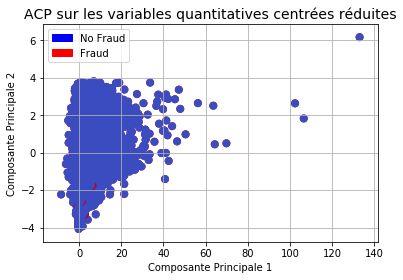

In [7]:
plt.figure()

plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(df["Class"] == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(df["Class"] == 1), cmap='coolwarm', label='Fraud', linewidths=2)
plt.title('ACP sur les variables quantitatives centrées réduites', fontsize=14)
plt.grid(True)
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")

blue_patch = mpatches.Patch(color='blue', label='No Fraud')
red_patch = mpatches.Patch(color='red', label='Fraud')
plt.legend(handles=[blue_patch, red_patch])
plt.show()

# Etape 2 : Création d'une base d'apprentissage et d'une base de test qui soient représentatif du nombre de transactions bancaires frauduleuses

En effet, il y a 492 transactions frauduleuses sur 284.315 transactions bancaires normales. 
Pour cette application spécifique à notre cas d'étude, peut-être est-ce pertinent de découper une base d'apprentissage où seront représentées 80% des transactions bancaires frauduleuses.

In [8]:
# Option pour créer une base d'apprentissage : celle qui permet d'avoir une base de données de "petite taille"
# et équilibrée par rapport à la variable de sortie "Class"

ratio_apprentissage = 0.8 # proportion de la base de données utilisée pour l'apprentissage

# sous-calculs
df_shuffle = df.sample(frac=1) # désordre aléatorie du jeu de données
num_fraude = df_shuffle.groupby('Class').size()[1] #combien de fraudes dans notre jeu de données
num_train = int(ratio_apprentissage * num_fraude + 1)

# base d'entrainement
df_fraude = df_shuffle.loc[df_shuffle['Class'] == 1][0:num_train]
df_non_fraude = df_shuffle.loc[df_shuffle['Class'] == 0][0:num_train]
df_train = pd.concat([df_fraude, df_non_fraude])
df_train = df_train.sample(frac=1)

# base de test
df_fraude = df_shuffle.loc[df_shuffle['Class'] == 1][num_train:num_fraude]
df_non_fraude = df_shuffle.loc[df_shuffle['Class'] == 0][num_train:num_fraude]
df_test = pd.concat([df_fraude, df_non_fraude])
df_test = df_test.sample(frac=1)

print( "Répartition dans le jeu d'apprentissage :", df_train.groupby('Class').size(),
      "\nRépartition dans le jeu de test :", df_test.groupby('Class').size() )

Répartition dans le jeu d'apprentissage : Class
0    394
1    394
dtype: int64 
Répartition dans le jeu de test : Class
0    98
1    98
dtype: int64


In [9]:
#Fonction qui détecte les outliers
def detect_outliers(df, variables):
    '''détection les individus dont une des variables d'entrée est en dehors de l'intervalle acceptable'''
    individus = [] # initialisation de la liste des individus outliers"
    # ...
    for var in variables:
        m = df[var].mean(axis=0)
        std = df[var].std(axis=0)
        mini = m - 3*std # seuil bas pour un outlier
        maxi = m + 3*std # seuil haut pour un outlier
        # ...
        individus_nouveaux = np.where( np.logical_or( df[var] < mini, df[var] > maxi ) )[0].tolist()
        individus = np.unique( individus + individus_nouveaux ).tolist()
    # ...
    return individus

# exécution de la fonction
variables = df_train.columns[1:29]
outliers = detect_outliers(df_train, variables)
#print( len(outliers), 'outliers sur', df_train.shape[0])

#df_train = df_train.drop(df_train.index[outliers]); # suppressions des valeurs

In [10]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train = df_train.drop('Class', axis=1)
y_train = df_train['Class']

X_test = df_test.drop('Class', axis=1)
y_test = df_test['Class']

# Etape 3 : Réduction de dimensions

### 1) Analyse en composantes principales (ACP)

In [11]:
# PCA Implementation
X_reduced_pca = PCA(n_components=2).fit_transform(X_train.values)
# other options for PCA :
#X_reduced_pca = PCA(n_components=2, svd_solver='full').fit_transform(X_train.values)
#X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X_train.values) # if the first one is too long to apply

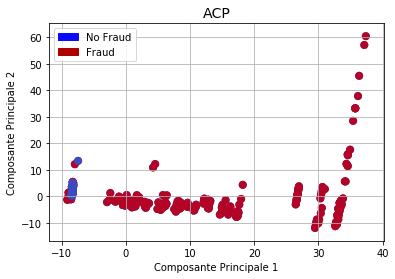

In [12]:
plt.figure()

plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_train == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_train == 1), cmap='coolwarm', label='Fraud', linewidths=2)
plt.title('ACP', fontsize=14)
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.grid(True)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')
plt.legend(handles=[blue_patch, red_patch])
plt.show()

Autre manière de faire la même figure avec un seul scatter plot

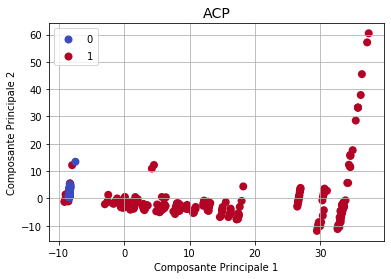

In [13]:
fig, ax = plt.subplots()
scatter = plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=y_train, cmap='coolwarm', linewidths=2)
ax.legend(*scatter.legend_elements(prop="colors")) # produce a legend with the unique colors from the scatter
# ax.legend(scatter.legend_elements(prop="colors")[0], ['regular','fraud'], title="Class") # produce a legend with the unique colors from the scatter
# ...
plt.title('ACP', fontsize=14)
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.grid(True)

In [14]:
mypca = PCA(n_components=2)
mypca.fit_transform(X_train.values)
mypca.explained_variance_ratio_

array([0.62068581, 0.10168818])

In [15]:
sum(mypca.explained_variance_ratio_)

0.7223739936295872

In [16]:
mypca.components_[1]

array([ 0.0189036 , -0.19485995,  0.13190393, -0.17481156, -0.00244073,
       -0.17413905,  0.08823767, -0.37569236, -0.39255629, -0.07447771,
       -0.13299566, -0.1354375 ,  0.1478034 , -0.02454533,  0.36640726,
       -0.05387631,  0.11630211,  0.13576134,  0.0164576 , -0.05975238,
        0.13050082, -0.43212054,  0.13953087,  0.09851469,  0.01775086,
       -0.04009742, -0.03270704, -0.31796188, -0.07868748, -0.01242816])

### 2) T-SNE

In [17]:
# T-SNE Implementation
tsne = TSNE(n_components=2, random_state=99) # model
X_reduced_tsne = tsne.fit_transform(X_train.values) # fit
#https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

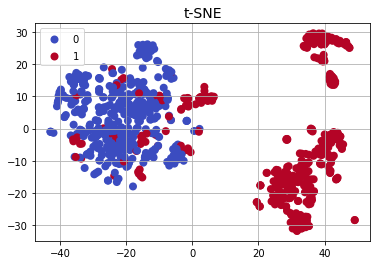

In [18]:
fig, ax = plt.subplots()
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=y_train, cmap='coolwarm', linewidths=2)
ax.legend(*scatter.legend_elements()) # produce a legend with the unique colors from the scatter
# ax.legend(scatter.legend_elements(prop="colors")[0], ['regular','fraud'], title="Class") # produce a legend with the unique colors from the scatter
# ...
plt.title('t-SNE', fontsize=14)
plt.grid(True)

# Etape 4 : Méthodes de clustering (apprentissage automatique non supervisé)

### 4.1. K-means appliqué sur les données projetées par t-SNE

In [19]:
from sklearn.cluster import KMeans

# exécution des k-means sur le nuage de point projeté par t-sne
kmeans = KMeans(n_clusters=3, random_state=0) # model
kmeans.fit( X_reduced_tsne[:,0:2] ) # fit

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [20]:
# résultats du clustering
kmeans.labels_ # numéro du cluster dans lequel sont chacun des individus (index : ligne) du dataframe
kmeans.cluster_centers_ # centres de chaque cluster

array([[ 40.180164 ,  24.02997  ],
       [-19.353537 ,   3.6495893],
       [ 33.612392 , -15.499419 ]], dtype=float32)

Text(0, 0.5, 'T-SNE var 2')

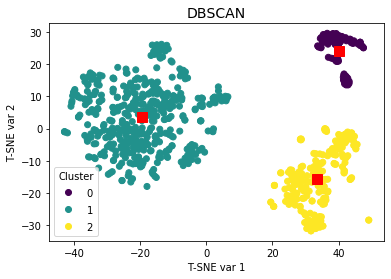

In [21]:
# représentation sur la projection de t-sne le résultat de k-means
cluster = kmeans.predict(X_reduced_tsne[:,0:2]) # ici, équivalent à : kmeans.labels_ car on le fait sur les donnée d'apprentissage
# ...
scatter = plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=cluster) #cmap='coolwarm'
leg = plt.legend(*scatter.legend_elements(prop="colors"), title='Cluster') # produce a legend with the unique colors from the scatter
plt.plot( kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 'sr', markersize=10) # centroids
# ...
plt.title('DBSCAN', fontsize=14)
plt.xlabel("T-SNE var 1")
plt.ylabel("T-SNE var 2")

### 4.2. DBSCAN appliqué sur les données projetées par t-SNE

In [22]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=5, min_samples=2)
dbscan.fit(X_reduced_tsne)

DBSCAN(algorithm='auto', eps=5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=2, n_jobs=None, p=None)

Text(0, 0.5, 'T-SNE var 2')

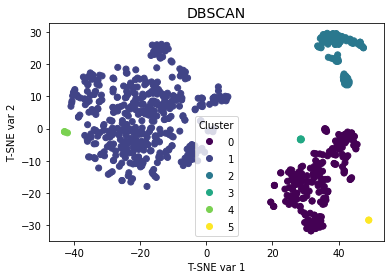

In [23]:
# représentation sur la projection de t-sne le résultat de k-means
cluster = dbscan.labels_
# ...
scatter = plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=cluster) #cmap='coolwarm'
leg = plt.legend(*scatter.legend_elements(prop="colors"), title='Cluster') # produce a legend with the unique colors from the scatter
# ...
plt.title('DBSCAN', fontsize=14)
plt.xlabel("T-SNE var 1")
plt.ylabel("T-SNE var 2")

# Etape 5 : Apprentissage automatique supervisé

### 5.0. Pré-requis : méthodes d'analyse génériques

Pour faciliter l'analyse, on crée une fonction qui affiche les métriques indiquant la qualité de la prévision

In [24]:
from sklearn.metrics import confusion_matrix # for model evaluation

def print_metrics( y_test, y_esti ):
    ''' confusion_matrix_test = confusion_matrix(y_test, y_esti_tree) '''
    # ...
    confusion_matrix_test = confusion_matrix( y_test, y_esti )
    # ...
    true_negative = confusion_matrix_test[0,0]
    false_positive = confusion_matrix_test[0,1]
    false_negative = confusion_matrix_test[1,0]
    true_positive = confusion_matrix_test[1,1]
    # ...
    sensitivity = true_positive / ( true_positive + false_negative )
    specificity = true_negative / ( true_negative + false_positive )
    accuracy = ( true_positive + true_negative ) / ( true_positive + true_negative + false_positive + false_negative )
    # ...
    print('accuracy :',np.round(100*accuracy,2),'%')
    print('sensitivity :',np.round(100*sensitivity,2),'%')
    print('specificity :',np.round(100*specificity,2),'%')
    print('true_positive :',true_positive)
    print('true_negative :',true_negative)
    print('false_positive :',false_positive)
    print('false_negative :',false_negative)
    # ...
    return None

In [25]:
from sklearn.metrics import roc_curve, auc # for model evaluation

def plot_roc_curve( y_test, y_pred_proba ):
    ''' plot the ROC curve and compute AUC '''
    # ...
    fpr, tpr, thresholds = roc_curve( y_test, y_pred_proba )
    # ...
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, '.-')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    # ...
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    # ...
    # Aire sous la courbe ROC (AUC)
    auc_metric = auc(fpr, tpr)
    print('Area under curve (AUC) :',auc_metric)
    # ...
    return None

Possibilité de création d'autres fonctions utiles :
* tracé des nuages de points (scatter) avec les prévisions (faux / vrais positifs / négatifs) sur le plan de t-SNE
* création d'un dataframe de comparaison de plusieurs méthodes de prévision
* application d'un centrage-réduction sur les données d'apprentissage, et appliquer cette transformation sur les données de test
* fonction générique de création d'un jeu d'apprentissage / de test suivant des caractéristiques à passer en paramètres
* application de la crossvalidation avec le choix de paramètres optimaux pour une méthode
* transformation de variables catégorielles en quantitatif (tableau disjonctif complet)
* etc.

### 5.1. Arbre de décision

In [26]:
from sklearn.tree import DecisionTreeClassifier

# Classification par les arbres de décision
dtc = DecisionTreeClassifier() # model
dtc.fit(X_train, y_train) # fit

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [27]:
# Prévision sur les données de test
y_pred = dtc.predict(X_test) # predict
dtc.score(X_test, y_test) # first evaluation based on accuracy

0.923469387755102

In [28]:
# Matrice de confusion et métriques
confusion_matrice_tree = confusion_matrix( y_test, y_pred )
print_metrics( y_test, y_pred )

accuracy : 92.35 %
sensitivity : 93.88 %
specificity : 90.82 %
true_positive : 92
true_negative : 89
false_positive : 9
false_negative : 6


### 5.2. Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Classification par une forêt aléatoire
rf = RandomForestClassifier(max_depth=10) # model / construction
rf.fit(X_train, y_train) # fit / apprentissage

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [30]:
# Prévision sur les données de test
y_pred = rf.predict(X_test) # predict / prévision : booléen True/False
y_pred_proba = rf.predict_proba(X_test)[:,1] # predict : avec probabilité d'être True/False entre 0 et 1
# The predicted class probability is the fraction of samples of the same class in a leaf.

In [31]:
# Matrice de confusion et métriques
confusion_matrice_rf = confusion_matrix( y_test, y_pred )
print_metrics( y_test, y_pred )

accuracy : 94.9 %
sensitivity : 91.84 %
specificity : 97.96 %
true_positive : 90
true_negative : 96
false_positive : 2
false_negative : 8


Area under curve (AUC) : 0.9773011245314451


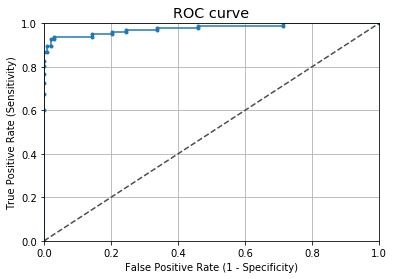

In [32]:
# plot ROC curve and compute area under curve (AUC)
plot_roc_curve( y_test, y_pred_proba )

### 5.3. K plus proches voisins (KNN)

In [33]:
# Application de la méthode de prévision sur le jeu d'entrainement
neigh = KNeighborsClassifier(n_neighbors=3)

neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [34]:
# évaluation de la matrice de confusion sur le jeu de test
y_esti_knn = neigh.predict(X_test)
y_esti_knn

array([1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0],
      dtype=int64)

In [35]:
confusion_matrice_knn = confusion_matrix(y_test, y_esti_knn)
confusion_matrice_knn

array([[92,  6],
       [ 8, 90]], dtype=int64)

In [36]:
sensitivity_knn = confusion_matrice_knn[1,1]/(confusion_matrice_knn[1,1]+confusion_matrice_knn[1,0])
sensitivity_knn

0.9183673469387755

### Réseau de neurones artificiel (ANN)

In [37]:
mlp = MLPClassifier(hidden_layer_sizes=(10), max_iter=20000,
                    solver='adam')
mlp.fit(X_train, y_train)
print("Training set score: %f" % mlp.score(X_train, y_train))

Training set score: 0.989848


In [38]:
#print("Test set score: %f" % mlp.score(X_test, y_test))
prediction = mlp.predict(X_test)

In [39]:
confusion_matrice = confusion_matrix(y_test, prediction)
print(confusion_matrice)

[[86 12]
 [ 6 92]]


In [40]:
specificity = confusion_matrice[0,0]/(confusion_matrice[0,0]+confusion_matrice[0,1])
print('Specificity : ', specificity)

sensitivity = confusion_matrice[1,1]/(confusion_matrice[1,1]+confusion_matrice[1,0])
print('Sensitivity : ', sensitivity )

Specificity :  0.8775510204081632
Sensitivity :  0.9387755102040817


In [ ]:
from sklearn.model_selection import cross_validate
cross_validate(mlp, X, y, cv=5)

### Permutation d'importance

In [ ]:
perm = PermutationImportance(mlp).fit(X_test, y_test)
eli5.show_weights(perm,feature_names = X_train.columns.tolist(),top=31)

In [ ]:
### Sans le drop
mlp = MLPClassifier(hidden_layer_sizes=(10), max_iter=100, solver='lbfgs', verbose=False)
mlp.fit(X_train, y_train)
print('Taux de précision sans drop', mlp.score(X_test, y_test)*100)

### Avec le drop
X_train_2=X_train.drop(['V18','V15','V25'],axis=1)
X_test_2=X_test.drop(['V18','V15','V25'],axis=1)

mlp2 = MLPClassifier(hidden_layer_sizes=(10), max_iter=20, solver='lbfgs', verbose=False)
mlp2.fit(X_train_2, y_train)
print('Taux de précision avec drop de V18, V15, V25', mlp2.score(X_test_2, y_test)*100)